## Importing necessary libraries/modules 

In [21]:
import cv2
import json
import numpy as np
import os
from scipy.io import loadmat
import dlib
from tqdm import tqdm
import scipy.io 
import pickle 

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import clone

from skimage.feature import hog
from skimage import data, color, exposure, io
from skimage.io import imread 
from skimage.transform import resize
from skimage.filters import gabor
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import optuna


%matplotlib inline

### Gabor Features 

Extracing Gabor features using the function gabor in scikit-image. 

In [ ]:
subjectIds = ['SN001', 'SN002', 'SN003', 'SN004', 'SN005','SN006','SN007','SN008', 'SN010', 'SN011','SN012','SN013', 'SN016', 'SN017', 'SN018', 'SN021', 'SN023', 'SN024', 'SN025', 'SN026', 'SN027', 'SN028','SN029', 'SN030','SN031','SN032' ]

In [22]:
# Define Gabor filter parameters
orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]  
frequencies = [0.2, 0.4, 0.6, 0.8] 

def extract_gabor_features(image_path):
    image = imread(image_path, as_gray=True)
    gabor_responses = []
    for theta in orientations:
        for frequency in frequencies:
            # Apply Gabor filter
            filtered, _ = gabor(image, frequency=frequency, theta=theta)
            # Extract magnitude of the response and flatten
            gabor_responses.extend(np.abs(filtered).flatten())
    
    # Compute histogram of Gabor responses
    hist, _ = np.histogram(gabor_responses, bins=20)  
    hist = hist.astype(float) / hist.sum()  # Normalize histogram
    
    return hist

# Calculate Gabor features for each cropped image
gabor_features = {}
for subject_id in tqdm(subjectIds, desc="Extracting Gabor features"):
    cropped_dir = os.path.join("croppedImg", subject_id)
    cropped_images = [f for f in os.listdir(cropped_dir) if f.endswith('.jpg')]
    gabor_features[subject_id] = [extract_gabor_features(os.path.join(cropped_dir, img)) for img in cropped_images]


Extracting Gabor features: 100%|██████████| 27/27 [12:04:19<00:00, 1609.61s/it]  


In [23]:
# Save the Gabor features to a file
with open('gabor_features.pkl', 'wb') as f:
    pickle.dump(gabor_features, f)


In [24]:
# To load the features back from the file
with open('gabor_features.pkl', 'rb') as f:
    gabor_features = pickle.load(f)

In [27]:
len(gabor_features) # Finding the number of features 

27

#### Plotting Average Gabors across all subjects

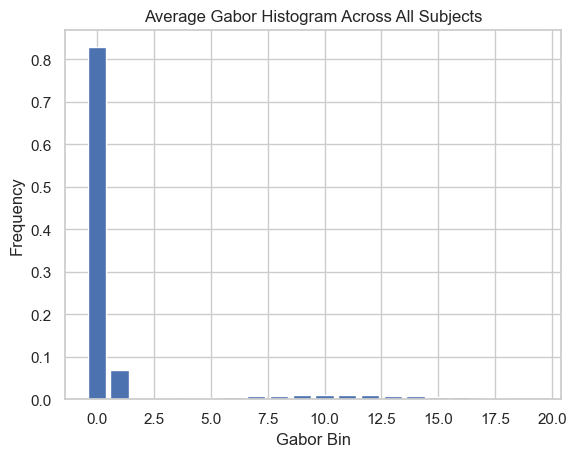

In [28]:
all_histograms = []
for subject_id in subjectIds:
    for hist in gabor_features[subject_id]:
        all_histograms.append(hist)

# Calculate the average histogram
average_histogram = np.mean(all_histograms, axis=0)

# Plot the average histogram
sns.set(style="whitegrid")
plt.bar(range(len(average_histogram)), average_histogram)
plt.title('Average Gabor Histogram Across All Subjects')
plt.xlabel('Gabor Bin')
plt.ylabel('Frequency')
plt.show()

/var/folders/_t/k4q8g4jd7kq8f8kh6qvvgs_c0000gn/T/ipykernel_32870/1524029027.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(average_histogram))), y=average_histogram, palette="Blues_d")


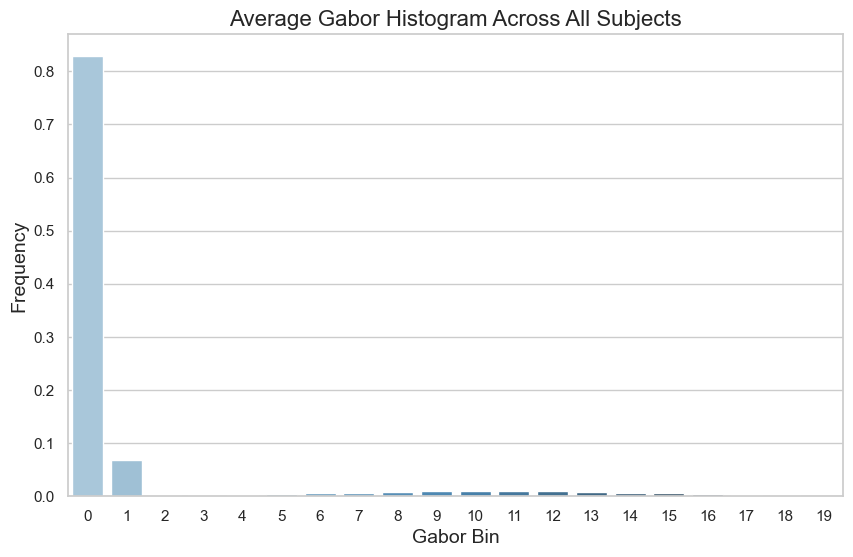

In [29]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the average histogram with seaborn color palette
sns.barplot(x=list(range(len(average_histogram))), y=average_histogram, palette="Blues_d")

# Add titles and labels with a larger font size
plt.title('Average Gabor Histogram Across All Subjects', fontsize=16)
plt.xlabel('Gabor Bin', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


### Assigning Each subject its features using the JSON folder.  

In [30]:
combined_features = []
labels = []

for subject_id in subjectIds:
    json_file = os.path.join('json', f'{subject_id}.json')
    with open(json_file, 'r') as file:
        data = json.load(file)
        for i, frame_data in enumerate(data):
            combined_features.append(gabor_features[subject_id][i])

            # Extract labels (AU intensities) with a default value of 0 if the key is not present
            au_intensities = [frame_data.get(f'au{j}', 0) for j in range(1, 27)]
            labels.append(au_intensities)


## Machine Learning Aspect 

First, doing SVM using scikit-learn on the data where the target variable are the labels (AU labels).

In [31]:
X = np.array(combined_features)
y = np.array(labels)

# Remove AUs with only one class
var_threshold = 0.0  # Threshold for variance
filtered_indices = [i for i in range(y.shape[1]) if np.var(y[:, i]) > var_threshold]
y_filtered = y[:, filtered_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_filtered, test_size=0.3, random_state=42)

# Train a multi-output SVM classifier
svm = SVC(kernel='linear', decision_function_shape='ovo')
multi_target_svm = MultiOutputClassifier(svm, n_jobs=-1)
multi_target_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_target_svm.predict(X_test)

# Calculate accuracy for each AU
accuracies = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
average_accuracy = np.mean(accuracies)
print(f'Average Accuracy: {average_accuracy}')
for i, acc in enumerate(accuracies):
    print(f'Accuracy for AU{filtered_indices[i]+1}: {acc}')



Average Accuracy: 0.7931919526517565
Accuracy for AU1: 0.8008153904956046
Accuracy for AU2: 0.9550515989298
Accuracy for AU4: 0.7518155179003695
Accuracy for AU5: 0.9921518664798064
Accuracy for AU6: 0.882150592432157
Accuracy for AU9: 0.8602879347687603
Accuracy for AU12: 0.8383997961523761
Accuracy for AU17: 0.9937826474710154
Accuracy for AU20: 0.9942158236718053
Accuracy for AU25: 0.3347432793986495
Accuracy for AU26: 0.32169703146897694


In [32]:
#Calculating Precision, Recall, F1-score
precision = [precision_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]
recall = [recall_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]
f1 = [f1_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]


average_recall = np.mean(recall)
print(f'Average Recall: {average_recall}')
for i, rec in enumerate(recall):
    print(f'Recall for AU{filtered_indices[i]+1}: {rec}')

average_f1 = np.mean(f1)
print(f'Average F1: {average_f1}')
for i, f1 in enumerate(f1):
    print(f'F1 for AU{filtered_indices[i]+1}: {f1}')

average_precision = np.mean(precision)
print(f'Average Precision: {average_precision}')
for i, prec in enumerate(precision):
    print(f'Precision for AU{filtered_indices[i]+1}: {prec}')

/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Average Recall: 0.23787878787878788
Recall for AU1: 0.16666666666666666
Recall for AU2: 0.16666666666666666
Recall for AU4: 0.16666666666666666
Recall for AU5: 0.3333333333333333
Recall for AU6: 0.25
Recall for AU9: 0.16666666666666666
Recall for AU12: 0.25
Recall for AU17: 0.3333333333333333
Recall for AU20: 0.3333333333333333
Recall for AU25: 0.2
Recall for AU26: 0.25
Average F1: 0.20812160900484783
F1 for AU1: 0.14823199807564416
F1 for AU2: 0.16283484955121688
F1 for AU4: 0.14305454545454546
F1 for AU5: 0.3320201580926556
F1 for AU6: 0.2343464428349015
F1 for AU9: 0.15414960209295
F1 for AU12: 0.22802433885901202
F1 for AU17: 0.3322938765772904
F1 for AU20: 0.332366507800621
F1 for AU25: 0.10031690275285403
F1 for AU26: 0.12169847696163485
Average Precision: 0.193838396707552
Precision for AU1: 0.13346923174926742
Precision for AU2: 0.1591752664883
Precision for AU4: 0.12530258631672825
Precision for AU5: 0.3307172888266021
Precision for AU6: 0.22053764810803925
Precision for AU9: 

### Comparing Various ML Classifiers 

To find the best classifer on the dataset, we ran multiple classifers using MultiOutputClassifer in scikit-learn. 
Then, the accuracy of each classifer was plot using matplotlib libary. 

Training SVM...
Training Random Forest...
Training Decision Tree...
Training Naive Bayes...
Training KNN...


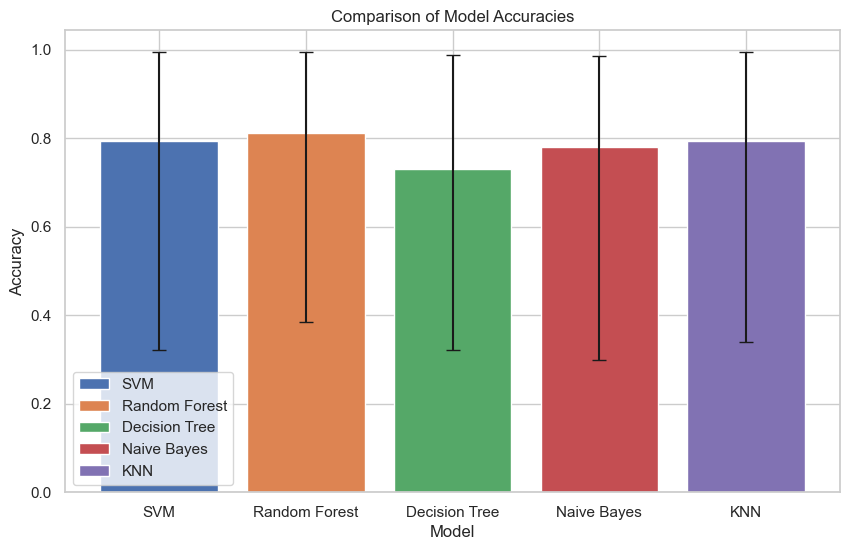

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_filtered, test_size=0.3, random_state=42)

# Define the models to compare
models = {
    'SVM': MultiOutputClassifier(SVC(kernel='linear', decision_function_shape='ovo')),
    'Random Forest': MultiOutputClassifier(RandomForestClassifier()),
    'Decision Tree': MultiOutputClassifier(DecisionTreeClassifier()),
    'Naive Bayes': MultiOutputClassifier(GaussianNB()),
    'KNN': MultiOutputClassifier(KNeighborsClassifier())
}

# Initialize a dictionary to store the accuracies for each model
model_accuracies = {model_name: [] for model_name in models.keys()}

# Train each model and calculate accuracies
for model_name, model in models.items():
    print(f'Training {model_name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
    model_accuracies[model_name] = accuracies

# Calculate minimum, maximum, and average accuracies for each model
model_stats = {model_name: {'min': min(acc), 'max': max(acc), 'avg': np.mean(acc)}
               for model_name, acc in model_accuracies.items()}

# Plot the results
plt.figure(figsize=(10, 6))
for model_name, stats in model_stats.items():
    plt.bar(model_name, stats['avg'], yerr=[[stats['avg'] - stats['min']], [stats['max'] - stats['avg']]], capsize=5, label=model_name)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.legend()
plt.show()


To get better comparison, we even compared other evaluation metrics like precision, recall, and F1 Score. Further plotted them for better understanding and comparison.

Training and evaluating SVM...
Training and evaluating Random Forest...
Training and evaluating Decision Tree...
Training and evaluating Naive Bayes...
Training and evaluating KNN...


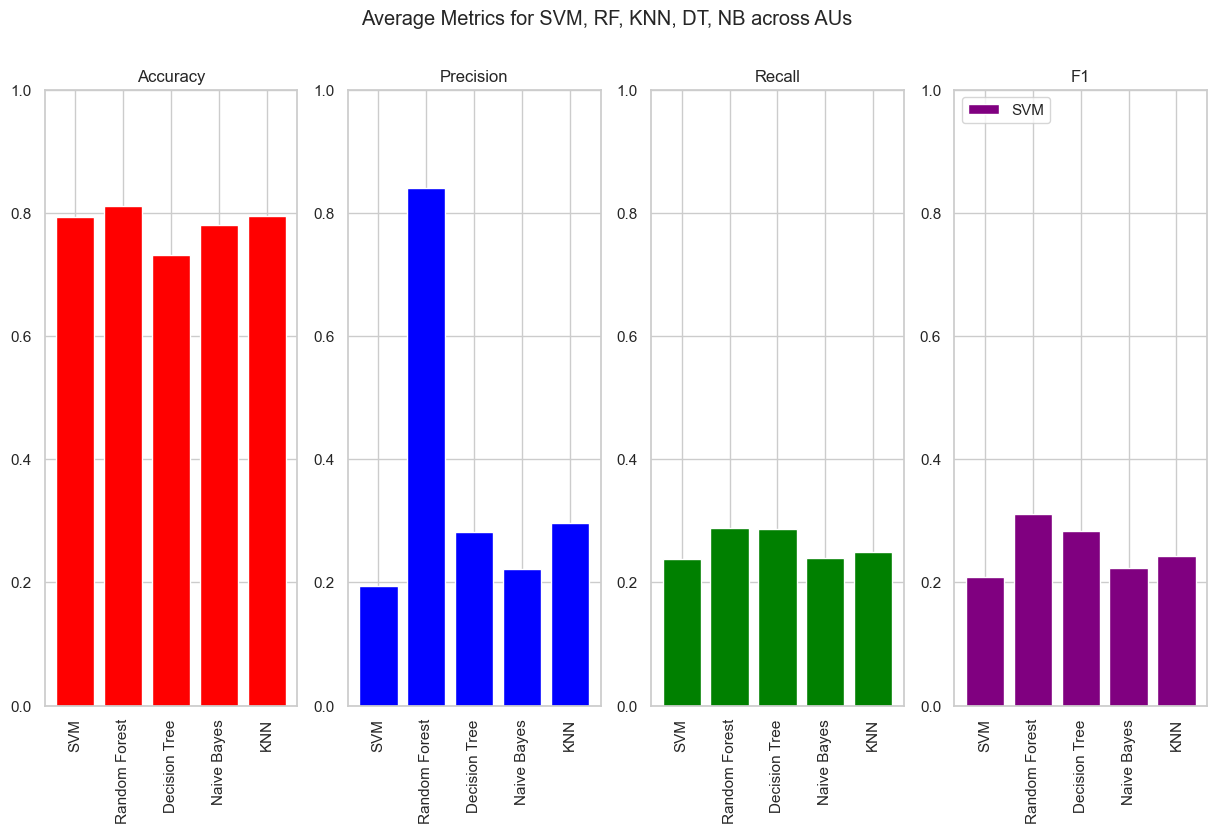

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize a dictionary to store the metrics for each model
model_metrics = {
    model_name: {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}
    for model_name in models.keys()
}

# Calculate metrics for each model
for model_name, model in models.items():
    print(f'Training and evaluating {model_name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics for each AU and average them
    accuracies = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
    precisions = [precision_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
    recalls = [recall_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
    f1_scores = [f1_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
    
    model_metrics[model_name]['Accuracy'] = np.mean(accuracies)
    model_metrics[model_name]['Precision'] = np.mean(precisions)
    model_metrics[model_name]['Recall'] = np.mean(recalls)
    model_metrics[model_name]['F1'] = np.mean(f1_scores)

# Define the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
# Define colors for each model
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot the results
plt.figure(figsize=(15, 8))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    plt.bar(models.keys(), [model_metrics[model_name][metric] for model_name in models.keys()], color=colors[i % len(colors)])
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
   

plt.suptitle('Average Metrics for SVM, RF, KNN, DT, NB across AUs')
plt.legend(models.keys(), loc='upper left')
plt.show()


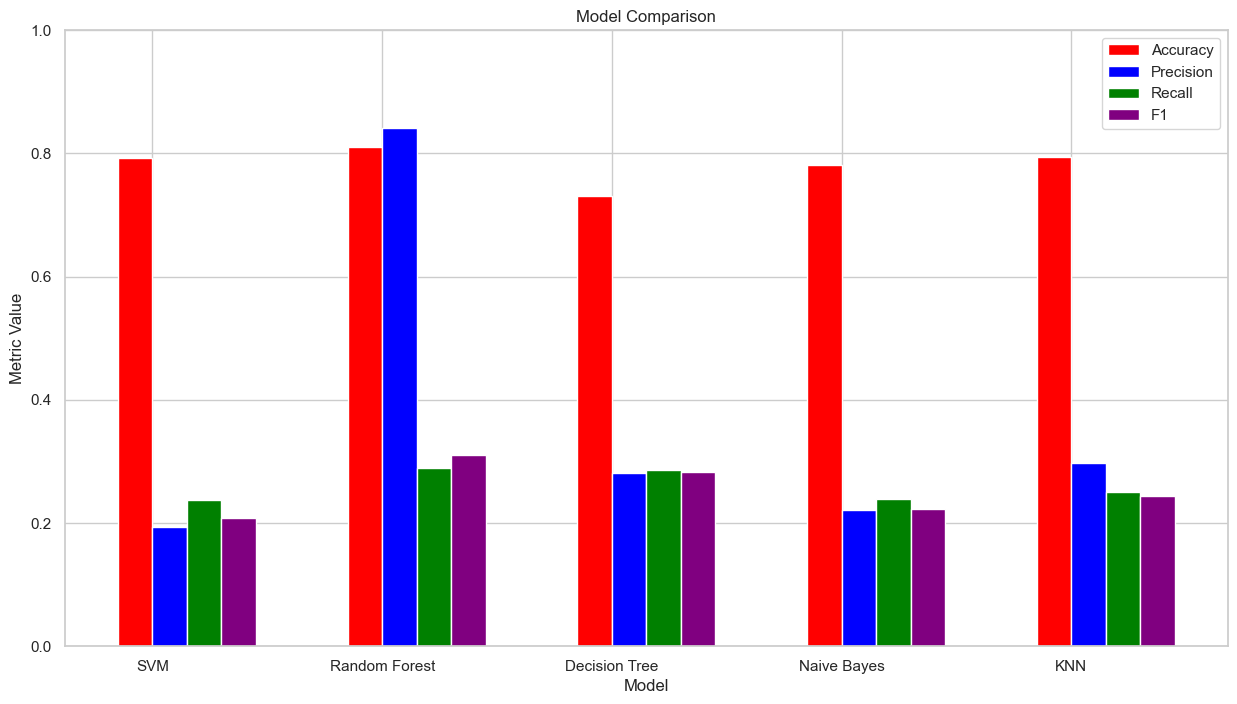

In [36]:
import matplotlib.pyplot as plt

# Define the metrics and colors for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot the results without error bars
plt.figure(figsize=(15, 8))
bar_width = 0.15  # Width of the bars
for i, metric in enumerate(metrics):
    # Calculate positions for each bar
    positions = np.arange(len(models)) + i * bar_width
    
    # Extract mean for the metric
    means = [model_metrics[model_name][metric] for model_name in models.keys()]
    plt.bar(positions, means, bar_width, color=colors[i], label=metric, capsize=5)

plt.xticks(np.arange(len(models)) + bar_width / 2, models.keys())
plt.title('Model Comparison')
plt.legend()
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()


### Running Random Forest Classifier 

In the above plots, we saw RF is doing the best amongst all. So we evaluated for all AUs. 

In [38]:
# Train a multi-output Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100)  # You can adjust the number of trees
multi_target_rf = MultiOutputClassifier(random_forest, n_jobs=-1)
multi_target_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_target_rf.predict(X_test)

# Calculate accuracy for each AU
accuracies = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
average_accuracy = np.mean(accuracies)
print(f'Average Accuracy: {average_accuracy}')
for i, acc in enumerate(accuracies):
    print(f'Accuracy for AU{filtered_indices[i]+1}: {acc}')


/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Average Accuracy: 0.81104946779555
Accuracy for AU1: 0.810243343101032
Accuracy for AU2: 0.9571410370747866
Accuracy for AU4: 0.7644031086762645
Accuracy for AU5: 0.9926869664925468
Accuracy for AU6: 0.8883424640081539
Accuracy for AU9: 0.8674735635112754
Accuracy for AU12: 0.8457383106128169
Accuracy for AU17: 0.9940884189068672
Accuracy for AU20: 0.9946235189196075
Accuracy for AU25: 0.4226525672060135
Accuracy for AU26: 0.38415084724168685


In [39]:
#Calculating Precision, Recall, F1-score
precision = [precision_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]
recall = [recall_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]
f1 = [f1_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]

average_recall = np.mean(recall)
print(f'Average Recall: {average_recall}')
for i, rec in enumerate(recall):
    print(f'Recall for AU{filtered_indices[i]+1}: {rec}')

average_f1 = np.mean(f1)
print(f'Average F1: {average_f1}')
for i, f1 in enumerate(f1):
    print(f'F1 for AU{filtered_indices[i]+1}: {f1}')

average_precision = np.mean(precision)
print(f'Average Precision: {average_precision}')
for i, prec in enumerate(precision):
    print(f'Precision for AU{filtered_indices[i]+1}: {prec}')

/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Average Recall: 0.2887257336955567
Recall for AU1: 0.20783152663856
Recall for AU2: 0.21128126747641893
Recall for AU4: 0.21075824158549636
Recall for AU5: 0.373015873015873
Recall for AU6: 0.2910614292358913
Recall for AU9: 0.21115081433060542
Recall for AU12: 0.28856505567788543
Recall for AU17: 0.3508771929824561
Recall for AU20: 0.3877002413868773
Recall for AU25: 0.2869794743492667
Recall for AU26: 0.35676195397179306
Average F1: 0.3100196273662155
F1 for AU1: 0.2274636704938664
F1 for AU2: 0.2473034648764436
F1 for AU4: 0.22790869461527286
F1 for AU5: 0.40685683875254125
F1 for AU6: 0.3129014330493045
F1 for AU9: 0.23915057199049908
F1 for AU12: 0.3022880226461355
F1 for AU17: 0.3656781791378003
F1 for AU20: 0.432725304368095
F1 for AU25: 0.29786772125634364
F1 for AU26: 0.35007199984206855
Average Precision: 0.8360692823073361
Precision for AU1: 0.9345128361687803
Precision for AU2: 0.984719582888773
Precision for AU4: 0.9085415339319883
Precision for AU5: 0.9975610170643824
Pre

#### Boosting 

Next, we did boosting using the AdaBoostClassifier in the scikit-learn over RF as it was doing the best job. Further evaluation was also done. 

In [40]:
# Train a multi-output AdaBoost classifier with RandomForest as the base estimator
ada_boost = AdaBoostClassifier(RandomForestClassifier(n_estimators=50))
multi_target_ada = MultiOutputClassifier(ada_boost, n_jobs=-1)
multi_target_ada.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_target_ada.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score for each AU
accuracies = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
precisions = [precision_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
f1_scores = [f1_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(f'Average Accuracy: {average_accuracy}')
print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1_score}')

for i, (acc, prec, rec, f1) in enumerate(zip(accuracies, precisions, recalls, f1_scores)):
    print(f'AU{filtered_indices[i]+1}: Accuracy={acc}, Precision={prec}, Recall={rec}, F1 Score={f1}')


/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/aayushgupta/miniconda3/envs/Soft_Vul/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

### Bagging Classifier

In [ ]:

# Train a multi-output AdaBoost classifier with RandomForest as the base estimator
ada_boost = AdaBoostClassifier(BaggingClassifier(n_estimators=50))
multi_target_ada = MultiOutputClassifier(ada_boost, n_jobs=-1)
multi_target_ada.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_target_ada.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score for each AU
accuracies = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
precisions = [precision_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
f1_scores = [f1_score(y_test[:, i], y_pred[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(f'Average Accuracy: {average_accuracy}')
print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1_score}')

for i, (acc, prec, rec, f1) in enumerate(zip(accuracies, precisions, recalls, f1_scores)):
    print(f'AU{filtered_indices[i]+1}: Accuracy={acc}, Precision={prec}, Recall={rec}, F1 Score={f1}')


/users/aayush/latest/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/users/aayush/latest/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/users/aayush/latest/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/users/aayush/latest/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
 

Average Accuracy: 0.9658479920345169
Average Precision: 0.915027904269168
Average Recall: 0.774536602904949
Average F1 Score: 0.8238689305552155
AU1: Accuracy=0.9528708927978758, Precision=0.9191379335675495, Recall=0.7797899816519326, F1 Score=0.8397201273249246
AU2: Accuracy=0.9857285097909061, Precision=0.9493271953538639, Recall=0.7182744227381058, F1 Score=0.8063590686328582
AU4: Accuracy=0.9780949220046465, Precision=0.936412528432676, Recall=0.824809791987304, F1 Score=0.8645768524398263
AU5: Accuracy=0.9943577829405907, Precision=0.6647765176784523, Recall=0.5057471264367815, F1 Score=0.5596582989959809
AU6: Accuracy=0.9581812147361434, Precision=0.9352591342907706, Recall=0.8779744942797302, F1 Score=0.9047258471146493
AU9: Accuracy=0.9880517756388981, Precision=0.979719056384548, Recall=0.6961560356530082, F1 Score=0.7771586405881696
AU12: Accuracy=0.9349485562562231, Precision=0.9172899721411275, Recall=0.8680176681053431, F1 Score=0.8907461876571166
AU17: Accuracy=0.9960172

### SMOTE boosting 

In [ ]:
class MultiOutputAdaBoost:
    def __init__(self, base_estimator=None, n_estimators=50):
        self.base_estimator = base_estimator if base_estimator is not None else RandomForestClassifier()
        self.n_estimators = n_estimators
        self.estimators_ = []

    def fit(self, X, Y):
        self.estimators_ = []
        smote = SMOTE()  # Initialize SMOTE
        for i in range(Y.shape[1]):
            X_resampled, y_resampled = smote.fit_resample(X, Y[:, i])  # Apply SMOTE
            model = AdaBoostClassifier(base_estimator=clone(self.base_estimator), n_estimators=self.n_estimators)
            model.fit(X_resampled, y_resampled)
            self.estimators_.append(model)
        return self

    def predict(self, X):
        predictions = []
        for model in self.estimators_:
            predictions.append(model.predict(X).reshape(-1, 1))
        return np.hstack(predictions)

# Initialize the multi-output AdaBoost classifier with Random Forest as the base estimator
multi_output_adaboost = MultiOutputAdaBoost(base_estimator=RandomForestClassifier(), n_estimators=50)

# Train the classifier
multi_output_adaboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_output_adaboost.predict(X_test)

# Calculate accuracy for each AU and average accuracy
accuracies = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
average_accuracy = np.mean(accuracies)

# Print the results
print(f'Average Accuracy: {average_accuracy}')
for i, acc in enumerate(accuracies):
    print(f'Accuracy for AU{filtered_indices[i]+1}: {acc}')


Average Accuracy: 0.7459012731740006
Accuracy for AU1: 0.6563144963144963
Accuracy for AU2: 0.9292383292383293
Accuracy for AU4: 0.6165110565110565
Accuracy for AU5: 0.9875184275184276
Accuracy for AU6: 0.8112039312039312
Accuracy for AU9: 0.7728746928746929
Accuracy for AU12: 0.753022113022113
Accuracy for AU17: 0.9897788697788698
Accuracy for AU20: 0.9908599508599508
Accuracy for AU25: 0.36324324324324325
Accuracy for AU26: 0.33434889434889437


In [ ]:

# Calculate precision, recall, and F1-score for each AU
precision = [precision_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]
recall = [recall_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]
f1 = [f1_score(y_test[:, i], y_pred[:, i], average='macro') for i in range(y_test.shape[1])]

average_recall = np.mean(recall)
print(f'Average Recall: {average_recall}')
for i, rec in enumerate(recall):
    print(f'Recall for AU{filtered_indices[i]+1}: {rec}')

average_f1 = np.mean(f1)
print(f'Average F1: {average_f1}')
for i, f1 in enumerate(f1):
    print(f'F1 for AU{filtered_indices[i]+1}: {f1}')

average_precision = np.mean(precision)
print(f'Average Precision: {average_precision}')
for i, prec in enumerate(precision):
    print(f'Precision for AU{filtered_indices[i]+1}: {prec}')

Average Recall: 0.2574286326531309
Recall for AU1: 0.17424702386930757
Recall for AU2: 0.17559957862512435
Recall for AU4: 0.18098681787299856
Recall for AU5: 0.33178140993891364
Recall for AU6: 0.2512745428044791
Recall for AU9: 0.17772054267978113
Recall for AU12: 0.2862386790175889
Recall for AU17: 0.3318833415719229
Recall for AU20: 0.33211450406825443
Recall for AU25: 0.2678658311928507
Recall for AU26: 0.32200268754321876
Average F1: 0.25649593121850567
F1 for AU1: 0.1729720665659573
F1 for AU2: 0.1770466704872019
F1 for AU4: 0.18096488691066084
F1 for AU5: 0.3312400072524683
F1 for AU6: 0.2502982434462411
F1 for AU9: 0.17803680437571814
F1 for AU12: 0.2858999352798279
F1 for AU17: 0.3316210609503112
F1 for AU20: 0.3318029981405605
F1 for AU25: 0.2608647037499556
F1 for AU26: 0.3207078662446595
Average Precision: 0.25688486834141105
Precision for AU1: 0.17229283631525513
Precision for AU2: 0.1801074636153341
Precision for AU4: 0.18227732370210117
Precision for AU5: 0.330700368615

### RNN 

##### Two LSTM Layers: 

1. 50 units and returns sequences. Here, the output is the full sequence to the next layer which is useful for maintaining temporal information throughout the network. 
2. Also 50 units but no return sequence. 

##### Two Dropout Layers
Positioned after each LSTM layer, with a dropout rate of 0.2. This will prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training time.
##### One Dense Layer 
A fully connected layer that outputs predictions for each AU. It uses a sigmoid activation function because your model likely predicts the presence or absence of each AU as a binary classification task. The sigmoid function is ideal here because it squashes its input to a range between 0 and 1, representing a probability.
        

#### Total Layers and Hidden Layers:

Total Layers: 5 (2 LSTM, 2 Dropout, 1 Dense) 

Hidden Layers: 4 (2 LSTM, 2 Dropout)

In [4]:
# Create RNN model
model = Sequential([
    LSTM(50, input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(y_filtered.shape[1], activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model on training data
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'RNN Model Accuracy: {scores[1]}')


2024-05-02 19:37:37.925603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 19:37:43.875680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/50


2024-05-02 19:37:57.228091: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/users/aayush/latest/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1834 - loss: -1.3062 - val_accuracy: 0.1814 - val_loss: -5.5130
Epoch 2/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1824 - loss: -6.6794 - val_accuracy: 0.1814 - val_loss: -10.1278
Epoch 3/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1831 - loss: -11.1855 - val_accuracy: 0.1814 - val_loss: -14.6815
Epoch 4/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1836 - loss: -15.8497 - val_accuracy: 0.1814 - val_loss: -19.2196
Epoch 5/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1846 - loss: -20.2840 - val_accuracy: 0.1814 - val_loss: -23.7636
Epoch 6/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1834 - loss: -24.5989 - val_accuracy: 0.1814 - val_loss: -28.2993
Epoch 7/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1826 - loss: -29.3429 - val_accuracy: 0.1814 - val_loss: -32.8307
Epoch 8/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1822 - l

### Hyperparameterization using OPTUNA

In [5]:
def objective(trial):
    # Hyperparameters to be tuned
    lstm_units = trial.suggest_categorical('lstm_units', [50, 100, 150])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Model construction
    model = Sequential([
        LSTM(lstm_units, input_shape=(1, X_train.shape[2]), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(y_filtered.shape[1], activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    # Fit the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    
    # Objective value to minimize
    return history.history['val_loss'][-1]


In [6]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-05-02 19:41:48,050] A new study created in memory with name: no-name-91248581-7dda-4d0d-9113-067ab0c946bb
/tmp/ipykernel_12515/2497591657.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
/tmp/ipykernel_12515/2497591657.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/users/aayush/latest/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__

In [9]:
print('Best trial:', study.best_trial.params)

# Rebuild and train the model with the best parameters
best_params = study.best_trial.params
model = Sequential([
    LSTM(best_params['lstm_units'], input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['lstm_units']),
    Dropout(best_params['dropout_rate']),
    Dense(y_filtered.shape[1], activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(best_params['learning_rate']), metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Predictions
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)  # Round predictions to get binary results

# Calculate metrics for each AU
accuracies = [accuracy_score(y_test[:, i], y_pred_rounded[:, i]) for i in range(y_test.shape[1])]
precisions = [precision_score(y_test[:, i], y_pred_rounded[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred_rounded[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
f1_scores = [f1_score(y_test[:, i], y_pred_rounded[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]

# Print metrics for each AU
for i, (acc, prec, rec, f1) in enumerate(zip(accuracies, precisions, recalls, f1_scores)):
    print(f'AU{filtered_indices[i]+1}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1 Score={f1:.4f}')

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(f'Best Model Average Accuracy: {average_accuracy:.4f}')
print(f'Best Model Average Precision: {average_precision:.4f}')
print(f'Best Model Average Recall: {average_recall:.4f}')
print(f'Best Model Average F1 Score: {average_f1_score:.4f}')

Best trial: {'lstm_units': 150, 'dropout_rate': 0.1608366146230273, 'learning_rate': 0.0007330124021490447}
Epoch 1/50


/users/aayush/latest/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1378/1378 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1821 - loss: -3.2658 - val_accuracy: 0.1814 - val_loss: -11.9670
Epoch 2/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1832 - loss: -14.3201 - val_accuracy: 0.1814 - val_loss: -21.9474
Epoch 3/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1824 - loss: -24.3552 - val_accuracy: 0.1814 - val_loss: -31.7918
Epoch 4/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1842 - loss: -34.3083 - val_accuracy: 0.1814 - val_loss: -41.6481
Epoch 5/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1823 - loss: -43.9948 - val_accuracy: 0.1814 - val_loss: -51.4993
Epoch 6/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1837 - loss: -53.7660 - val_accuracy: 0.1814 - val_loss: -61.3371
Epoch 7/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1847 - loss: -64.2598 - val_accuracy: 0.1814 - val_loss: -71.1723
Epoch 8/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.183

In [8]:
best_model = Sequential([
    LSTM(best_params['lstm_units'], input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['lstm_units']),
    Dropout(best_params['dropout_rate']),
    Dense(y_filtered.shape[1], activation='sigmoid')
])

best_model.compile(loss='binary_crossentropy', optimizer=Adam(best_params['learning_rate']), metrics=['accuracy'])
best_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Predictions
y_pred = best_model.predict(X_test)
y_pred_rounded = np.round(y_pred)  # Round predictions to get binary results

# Calculate metrics for each AU
accuracies = [accuracy_score(y_test[:, i], y_pred_rounded[:, i]) for i in range(y_test.shape[1])]
precisions = [precision_score(y_test[:, i], y_pred_rounded[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred_rounded[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]
f1_scores = [f1_score(y_test[:, i], y_pred_rounded[:, i], average='macro', zero_division=0) for i in range(y_test.shape[1])]

# Print metrics for each AU
for i, (acc, prec, rec, f1) in enumerate(zip(accuracies, precisions, recalls, f1_scores)):
    print(f'AU{filtered_indices[i]+1}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1 Score={f1:.4f}')

# Calculate and print average metrics
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(f'Best Model Average Accuracy: {average_accuracy:.4f}')
print(f'Best Model Average Precision: {average_precision:.4f}')
print(f'Best Model Average Recall: {average_recall:.4f}')
print(f'Best Model Average F1 Score: {average_f1_score:.4f}')


Epoch 1/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.1797 - loss: -3.2435 - val_accuracy: 0.1814 - val_loss: -11.8997
Epoch 2/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.1818 - loss: -14.4171 - val_accuracy: 0.1814 - val_loss: -21.8251
Epoch 3/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1830 - loss: -23.9206 - val_accuracy: 0.1814 - val_loss: -31.7045
Epoch 4/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1827 - loss: -34.0440 - val_accuracy: 0.1814 - val_loss: -41.5334
Epoch 5/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1835 - loss: -44.0277 - val_accuracy: 0.1814 - val_loss: -51.3828
Epoch 6/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1848 - loss: -53.2217 - val_accuracy: 0.1814 - val_loss: -61.2267
Epoch 7/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1844 - loss: -63.0427 - val_accuracy: 0.1814 - val_loss: -71.0619
Epoch 8/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc